In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')

image = Image.open('/content/drive/MyDrive/cool_purple.jpg')

Mounted at /content/drive


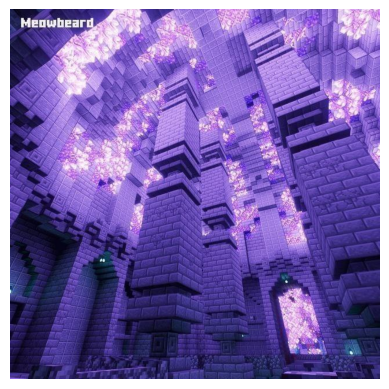

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

# 1. Переобразование изображения в тензор цветовых каналов RGB



In [ ]:
image = image.convert('RGB')
RGB = np.array(image)
R = RGB[:, :, 0]
G = RGB[:, :, 1]
B = RGB[:, :, 2]

print(RGB.shape)

(640, 640, 3)


# 2. Сингулярное разложение матрицы степенным методом


In [ ]:
def power_method(A, num_iter=100, tol=1e-6):
    v = np.random.rand(A.shape[1])
    v = v / np.linalg.norm(v)

    for _ in range(num_iter):
        v_next = A @ v

        if np.linalg.norm(v_next) == 0:
            break
        v_next = v_next / np.linalg.norm(v_next)

        if np.linalg.norm(v_next - v) < tol:
            break
        v = v_next

    lam = (v @ A @ v)
    return v, lam

def power_SVD(A, k=None, num_iter=100, tol=1e-6):
    m, n = A.shape
    B = A.copy()
    if k is None:
      k = min(m, n)

    U = []
    S = []
    V = []

    for _ in range(k):
        v, lam = power_method(B.T @ B, num_iter, tol)
        sigma = np.sqrt(lam)
        u = A @ v
        u = u / np.linalg.norm(u)

        U.append(u)
        V.append(v)
        S.append(sigma)

        B = B - sigma * np.outer(u, v)

    U = np.column_stack(U)
    V = np.column_stack(V)
    S = np.array(S)

    return U, S, V.T

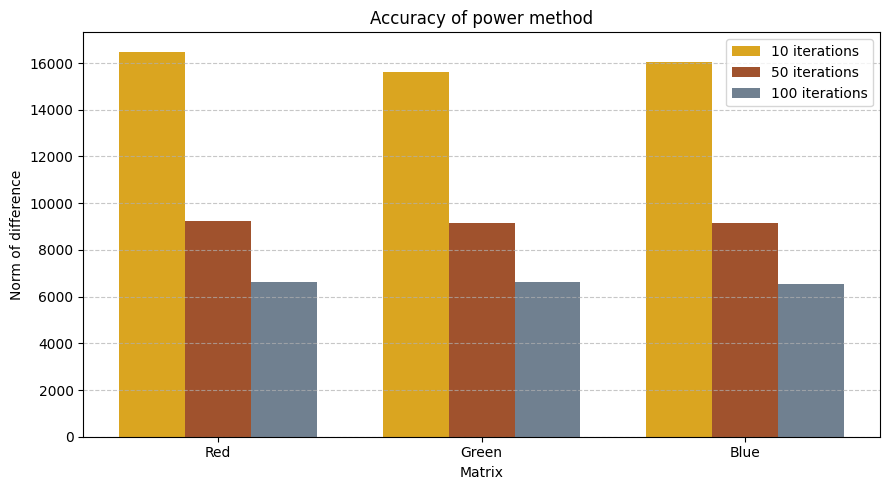

In [ ]:
def norm_dif(A, num_iter):
  U, S, VT = power_SVD(A, num_iter)
  S = np.diag(S)
  A_approx = U @ S @ VT

  return np.linalg.norm(A - A_approx)

labels = ['Red', 'Green', 'Blue']
x = np.arange(len(labels))

iter_10 = [norm_dif(R, 10), norm_dif(G, 10), norm_dif(B, 10)]
iter_50 = [norm_dif(R, 50), norm_dif(G, 50), norm_dif(B, 50)]
iter_100 = [norm_dif(R, 100), norm_dif(G, 100), norm_dif(B, 100)]

width = 0.25

plt.figure(figsize=(9, 5))
plt.bar(x - width, iter_10, width, label='10 iterations', color='goldenrod')
plt.bar(x, iter_50, width, label='50 iterations', color='sienna')
plt.bar(x + width, iter_100, width, label='100 iterations', color='slategray')

plt.xlabel('Matrix')
plt.ylabel('Norm of difference')
plt.title('Accuracy of power method')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3.1. Распределение сингулярных чисел

In [ ]:
R_U, R_S, R_Vt = power_SVD(R)
G_U, G_S, G_Vt = power_SVD(G)
B_U, B_S, B_Vt = power_SVD(B)

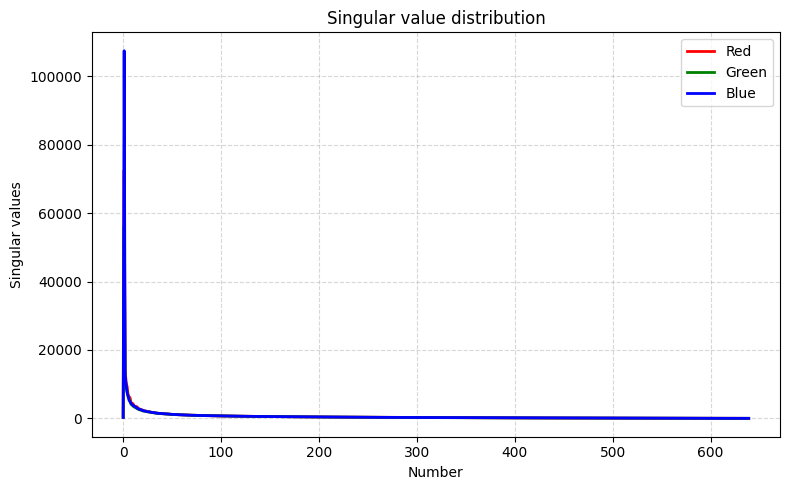

In [ ]:
x = list(range(0, len(R)))

plt.figure(figsize=(8, 5))
plt.plot(x, R_S.flatten(), label='Red', color='red', linewidth=2)
plt.plot(x, G_S.flatten(), label='Green', color='green', linewidth=2)
plt.plot(x, B_S.flatten(), label='Blue', color='blue', linewidth=2)

plt.title('Singular value distribution')
plt.xlabel('Number')
plt.ylabel('Singular values')
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

# 3.2. Усечённое сингулярное разложение

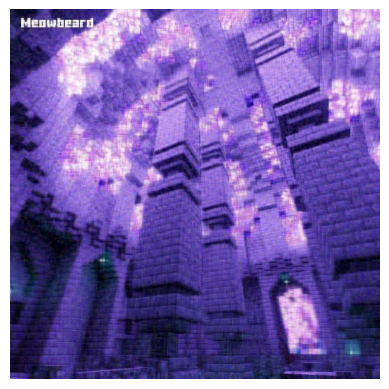

In [ ]:
amt_sigmas = 50
lenght_img = len(R)

R_U_approx, R_S_approx, R_Vt_approx = power_SVD(R, amt_sigmas)
G_U_approx, G_S_approx, G_Vt_approx = power_SVD(G, amt_sigmas)
B_U_approx, B_S_approx, B_Vt_approx = power_SVD(B, amt_sigmas)

R_S_approx = np.diag(R_S_approx)
G_S_approx = np.diag(G_S_approx)
B_S_approx = np.diag(B_S_approx)

R_approx = R_U_approx @ R_S_approx @ R_Vt_approx
G_approx = G_U_approx @ G_S_approx @ G_Vt_approx
B_approx = B_U_approx @ B_S_approx @ B_Vt_approx

RGB_approx = np.stack((R_approx, G_approx, B_approx), axis=-1)
RGB_approx = np.clip(RGB_approx, 0, 255).astype(np.uint8)
image_approx = Image.fromarray(RGB_approx)

plt.imshow(image_approx)
plt.axis('off')
plt.show()

Для приемлемого качетсва картинки достаточно 40-70 сингулярных чисел, что сходится с окончанием пика на графике.

# 4. Сингулярное разложение матрицы методом вращений Якоби

In [ ]:
def Jacobi_SVD(A, max_iterations=100, tol=1e-10):
    A = np.array(A, dtype=np.float64)
    m, n = A.shape
    U = np.eye(m)
    V = np.eye(n)
    S = A.copy()

    scale = np.linalg.norm(S)
    if scale == 0:
        return U, np.zeros(min(m, n)), V.T
    S /= scale

    eps = np.finfo(float).eps

    for iteration in range(max_iterations):
        changed = False
        for p in range(n):
            for q in range(p + 1, n):
                Ap = S[:, p]
                Aq = S[:, q]

                alpha = np.dot(Ap, Ap)
                beta = np.dot(Aq, Aq)
                gamma = np.dot(Ap, Aq)

                threshold = tol * np.sqrt(alpha * beta) + eps
                if abs(gamma) < threshold:
                    continue

                changed = True
                zeta = (beta - alpha) / (2 * gamma)
                t = np.sign(zeta) / (abs(zeta) + np.sqrt(1 + zeta**2))
                c = 1 / np.sqrt(1 + t**2)
                s = c * t

                S_i_p = S[:, p].copy()
                S_i_q = S[:, q].copy()
                S[:, p] = c * S_i_p - s * S_i_q
                S[:, q] = s * S_i_p + c * S_i_q

                V_i_p = V[:, p].copy()
                V_i_q = V[:, q].copy()
                V[:, p] = c * V_i_p - s * V_i_q
                V[:, q] = s * V_i_p + c * V_i_q

        if not changed:
            break

    singular_values = np.linalg.norm(S, axis=0)
    sorted_indices = np.argsort(-singular_values)

    S_sorted = singular_values[sorted_indices] * scale
    U_final = S @ V[:, sorted_indices]
    U_final /= singular_values[sorted_indices]
    V_final = V[:, sorted_indices]

    return U_final, S_sorted, V_final.T

In [ ]:
R_U_jacobi, R_S_jacobi, R_Vt_jacobi = Jacobi_SVD(R, 10)
R_U_pm, R_S_pm, R_Vt_pm = power_SVD(R, None, 10)

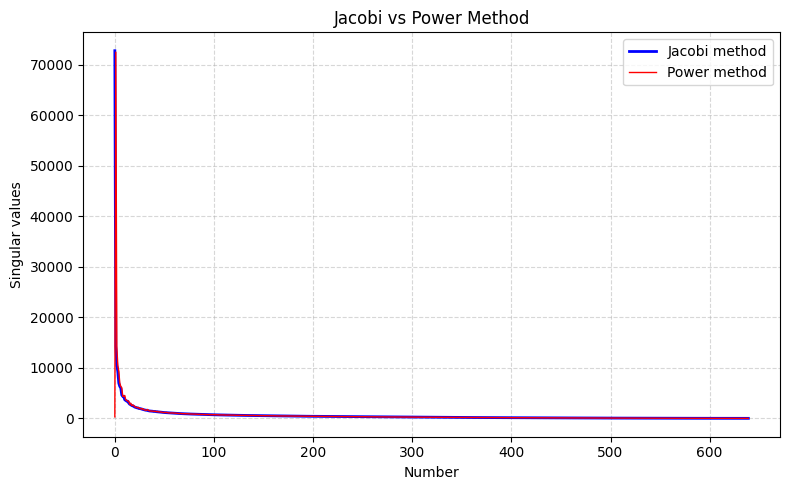

In [ ]:
x = list(range(0, len(R)))

plt.figure(figsize=(8, 5))

plt.plot(x, R_S_jacobi.flatten(), label='Jacobi method', color='blue', linewidth=2)
plt.plot(x, R_S_pm.flatten(), label='Power method', color='red', linewidth=1)

plt.title('Jacobi vs Power Method')
plt.xlabel('Number')
plt.ylabel('Singular values')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', frameon=True)  # Добавление легенды

plt.tight_layout()
plt.show()

## Сравнение сложности методов:
Пусть n - минимальная сторона сматрицы, k - максимальное чсло итераций.
1. Power method:

  При поиске сингулярного числа умножаются матрицы, нормализуется вектор, происходит провека сходимости, то есть сложность O(2n^2 + k(n^2)). При нахождении k сингулярных чисел O(k(2n^2 + k(n^2)) или же O((kn)^2).

2. Jacoby method:

  Учитывая предобратку матрицы, 2 вложененных цикла в которых происходят операции с векторами сложность алгоритма будет примерно пропорционально O(k * n^3).


# 5. Сокращение числа вопросов и радость преподавателей

In [ ]:
import pandas as pd

In [ ]:

R_mean = np.mean(R)
G_mean = np.mean(G)
B_mean = np.mean(B)

R_std = np.std(R)
G_std = np.std(G)
B_std = np.std(B)
df = pd.DataFrame(data={"Канал": ['R', 'G', 'B'], "u": [R_mean, G_mean, B_mean], "sigma": [R_std, G_std, B_std], "k": [amt_sigmas, amt_sigmas, amt_sigmas]})
df.head()

,Канал,u,sigma,k
0,R,104.227227,64.134819,50
1,G,80.656001,52.866529,50
2,B,162.456289,60.632937,50


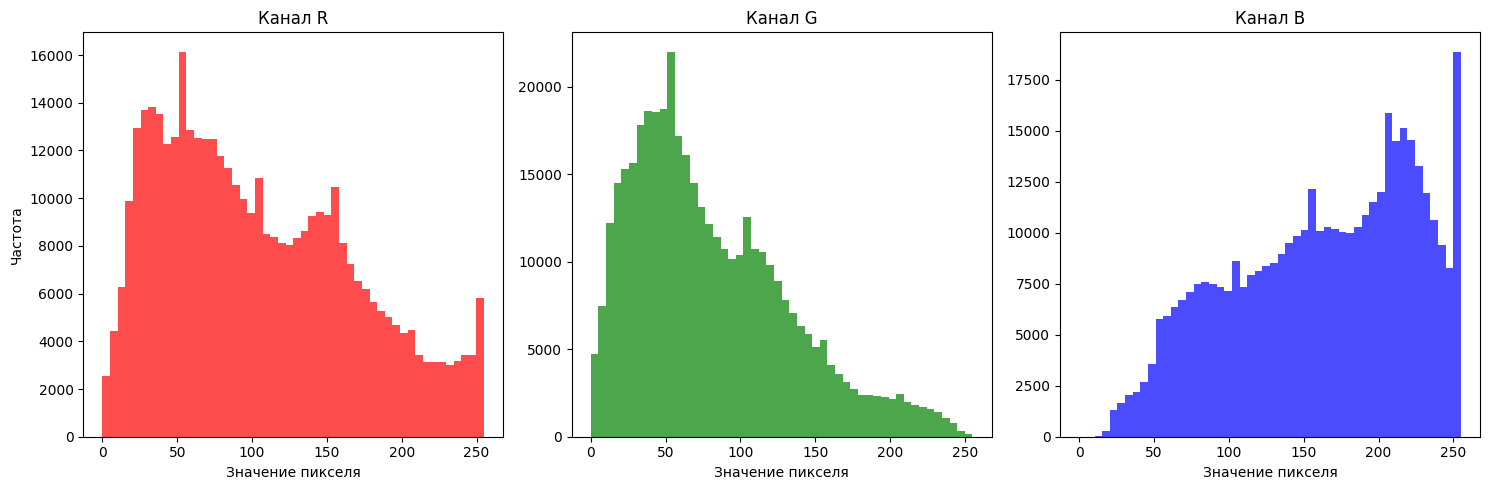

In [ ]:
plt.figure(figsize=(15, 5))

# Красный канал
plt.subplot(1, 3, 1)
plt.hist(R.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Канал R')
plt.xlabel('Значение пикселя')
plt.ylabel('Частота')

# Зеленый канал
plt.subplot(1, 3, 2)
plt.hist(G.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Канал G')
plt.xlabel('Значение пикселя')

# Синий канал
plt.subplot(1, 3, 3)
plt.hist(B.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Канал B')
plt.xlabel('Значение пикселя')

plt.tight_layout()
plt.show()

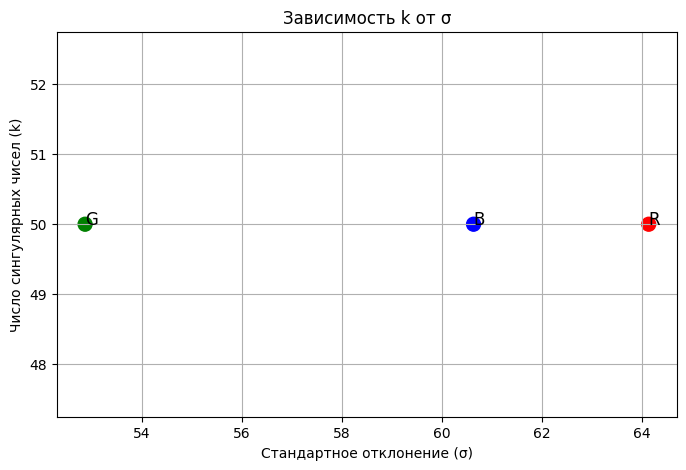

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(df['sigma'], df['k'], c=['red', 'green', 'blue'], s=100)
plt.xlabel('Стандартное отклонение (σ)')
plt.ylabel('Число сингулярных чисел (k)')
plt.title('Зависимость k от σ')
for i, txt in enumerate(df['Канал']):
    plt.annotate(txt, (df['sigma'][i], df['k'][i]), fontsize=12)
plt.grid(True)
plt.show()

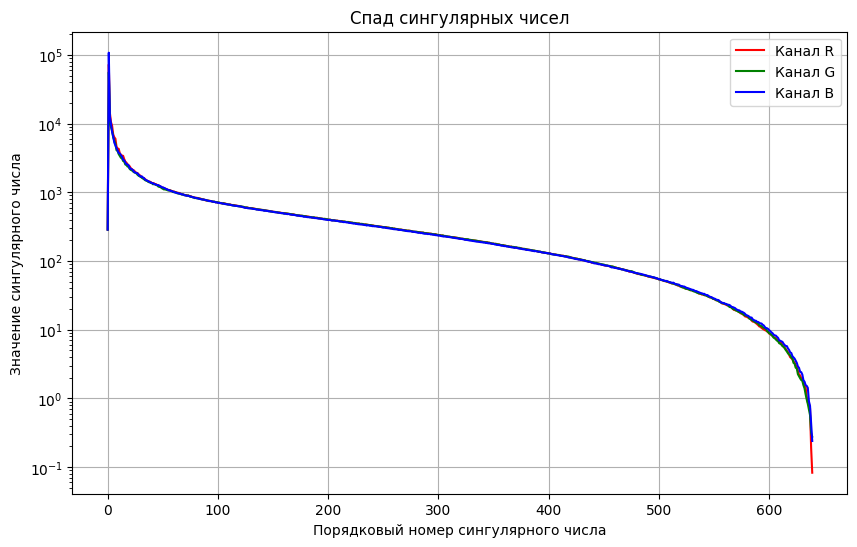

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(R_S, 'r-', label='Канал R')
plt.plot(G_S, 'g-', label='Канал G')
plt.plot(B_S, 'b-', label='Канал B')
plt.yscale('log')  # Логарифмическая шкала для наглядности
plt.xlabel('Порядковый номер сингулярного числа')
plt.ylabel('Значение сингулярного числа')
plt.title('Спад сингулярных чисел')
plt.legend()
plt.grid(True)
plt.show()